# Tool to extract usefull information from mlperf trace

In [1]:
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import json
import os
import seaborn as sns
from operator import itemgetter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

figsize=(10, 5)
font=10

plt.figure(dpi=600)
plt.rc('xtick', labelsize=font) 
plt.rc('font', size=font)
sns.set(font_scale=1.4, style="whitegrid");

<Figure size 3600x2400 with 0 Axes>

In [36]:
def trace_to_df(fname):
    with open(fname, "r") as f:
        print(f)
        j = json.load(f)
    if type(j) == dict:
        j = j['traceEvents']
        
    result = []
    for item in j:
        name = item['name']
        if name not in ["Latency", "Sample", "QuerySamplesComplete", "IssueQuery"]:
            continue

        args = item.get('args')
        d = {"ts": item['ts'], "name": name, "dur": item.get("dur")}

        if name == "Latency":
            d["issue_delay"] = args["issue_delay"] / 1e9
            d["issue_to_done"] = args["issue_to_done"] / 1e9
            result.append(d)
        elif name == "Sample":
            if args:
                d["issue_start_ns"] = args["issue_start_ns"]
                d["complete_ns"] = args["complete_ns"]
                d["issue_to_done"] = (args["complete_ns"] - args["issue_start_ns"]) / 1e9
                result.append(d)
        elif name == "QuerySamplesComplete":
            result.append(d)
        elif name == "IssueQuery":
            result.append(d)

    df = pd.DataFrame(result)
    df = df.sort_values(by=["ts"])
    return df

BINS = 10

In [37]:
# Fixing bin edges
HIST_BINS = np.linspace(0, 1000000, 100)

In [38]:
df = trace_to_df('/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/none-resnet-1-32-S-1-10/mlperf_log_trace.json')
df.describe()

<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>


,ts,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
count,4.802000e+04,24010.000000,1.200500e+04,24010.000000,1.200500e+04,1.200500e+04
mean,4.133834e+07,3873.221525,1.697624e+01,11.016417,1.697624e+10,2.799266e+10
std,2.852758e+07,7212.683331,1.416478e+01,2.908724,1.416478e+10,1.591214e+10
min,1.960050e+05,3.011000,2.220000e-07,0.146377,2.220000e+02,1.463859e+08
25%,1.781401e+07,6.087000,2.188979e+00,12.145755,2.188979e+09,1.435780e+10
50%,3.751535e+07,45.319500,1.575882e+01,12.261240,1.575882e+10,2.800297e+10
75%,5.730396e+07,5077.102750,2.938598e+01,12.307844,2.938598e+10,4.166818e+10
max,1.156422e+08,85201.312000,4.319503e+01,13.140706,4.319503e+10,5.553629e+10


In [39]:
df["name"].unique()

array(['Sample', 'Latency', 'IssueQuery', 'QuerySamplesComplete'],
      dtype=object)

In [40]:
df

,ts,name,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
32,1.960050e+05,Sample,NaN,NaN,0.146377,8660.0,146385940.0
31,1.960050e+05,Latency,NaN,0.000009,0.146377,NaN,NaN
0,1.960152e+05,IssueQuery,117.724,NaN,NaN,NaN,NaN
42,2.132605e+05,Sample,NaN,NaN,0.158766,88964.0,158854679.0
41,2.132605e+05,Latency,NaN,0.000089,0.158766,NaN,NaN
...,...,...,...,...,...,...,...
48007,1.156336e+08,QuerySamplesComplete,5.511,NaN,NaN,NaN,NaN
48010,1.156343e+08,QuerySamplesComplete,5.612,NaN,NaN,NaN,NaN
48013,1.156369e+08,QuerySamplesComplete,6.510,NaN,NaN,NaN,NaN
48016,1.156420e+08,QuerySamplesComplete,10.615,NaN,NaN,NaN,NaN


In [41]:
df1 = df[df["name"].isin(["Sample"])]
df1

,ts,name,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
32,1.960050e+05,Sample,NaN,NaN,0.146377,8.660000e+03,1.463859e+08
42,2.132605e+05,Sample,NaN,NaN,0.158766,8.896400e+04,1.588547e+08
49,2.151299e+05,Sample,NaN,NaN,0.180541,6.118800e+04,1.806019e+08
56,2.222754e+05,Sample,NaN,NaN,0.205071,8.422600e+04,2.051549e+08
71,2.367617e+05,Sample,NaN,NaN,0.238382,1.121140e+05,2.384945e+08
...,...,...,...,...,...,...,...
48006,6.018522e+07,Sample,NaN,NaN,12.264782,4.318361e+10,5.544839e+10
48009,6.019079e+07,Sample,NaN,NaN,12.255490,4.318802e+10,5.544351e+10
48012,6.019285e+07,Sample,NaN,NaN,12.249021,4.319503e+10,5.544405e+10
48018,6.019572e+07,Sample,NaN,NaN,12.254237,4.319224e+10,5.544648e+10


In [8]:
df1 = df[df["name"].isin(["IssueQuery"])]
df1

,ts,name,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
0,1.960152e+05,IssueQuery,117.724,NaN,NaN,NaN,NaN
1,2.133538e+05,IssueQuery,73.206,NaN,NaN,NaN,NaN
2,2.151961e+05,IssueQuery,1279.242,NaN,NaN,NaN,NaN
3,2.223629e+05,IssueQuery,63.277,NaN,NaN,NaN,NaN
4,2.368800e+05,IssueQuery,114.567,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
44163,1.033688e+08,IssueQuery,9974.363,NaN,NaN,NaN,NaN
44170,1.033788e+08,IssueQuery,9063.663,NaN,NaN,NaN,NaN
44171,1.033879e+08,IssueQuery,79.233,NaN,NaN,NaN,NaN
44181,1.033880e+08,IssueQuery,3874.435,NaN,NaN,NaN,NaN


In [9]:
df1 = df[df["name"].isin(["Latency"])]
df1

,ts,name,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
31,1.960050e+05,Latency,NaN,8.660000e+00,1.463773e+05,NaN,NaN
41,2.132605e+05,Latency,NaN,8.896400e+01,1.587657e+05,NaN,NaN
48,2.151299e+05,Latency,NaN,6.118800e+01,1.805407e+05,NaN,NaN
55,2.222754e+05,Latency,NaN,8.422600e+01,2.050707e+05,NaN,NaN
70,2.367617e+05,Latency,NaN,1.121140e+02,2.383824e+05,NaN,NaN
...,...,...,...,...,...,...,...
48005,6.018522e+07,Latency,NaN,4.318361e+07,1.226478e+07,NaN,NaN
48008,6.019079e+07,Latency,NaN,4.318802e+07,1.225549e+07,NaN,NaN
48011,6.019285e+07,Latency,NaN,4.319503e+07,1.224902e+07,NaN,NaN
48017,6.019572e+07,Latency,NaN,4.319224e+07,1.225424e+07,NaN,NaN


In [10]:
df1 = df[df["name"].isin(["QuerySamplesComplete"])]
df1

,ts,name,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
33,3.423921e+05,QuerySamplesComplete,26.157,NaN,NaN,NaN,NaN
43,3.721166e+05,QuerySamplesComplete,19.930,NaN,NaN,NaN,NaN
50,3.957332e+05,QuerySamplesComplete,26.923,NaN,NaN,NaN,NaN
57,4.274315e+05,QuerySamplesComplete,21.168,NaN,NaN,NaN,NaN
72,4.752575e+05,QuerySamplesComplete,20.600,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
48007,1.156336e+08,QuerySamplesComplete,5.511,NaN,NaN,NaN,NaN
48010,1.156343e+08,QuerySamplesComplete,5.612,NaN,NaN,NaN,NaN
48013,1.156369e+08,QuerySamplesComplete,6.510,NaN,NaN,NaN,NaN
48016,1.156420e+08,QuerySamplesComplete,10.615,NaN,NaN,NaN,NaN


# server scenario

In [20]:
import pandas as pd
import glob
# import plotly.plotly as py
import plotly.graph_objs as go

from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

import numpy as np
import matplotlib.pyplot as plt
# include if using a Jupyter notebook
# %matplotlib inline

path = "/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/"
all_files = glob.glob(path + "*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.head()

ValueError: No objects to concatenate

In [21]:
import pandas as pd
import glob
# import plotly.plotly as py
import plotly.graph_objs as go

from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

import numpy as np
import matplotlib.pyplot as plt
# include if using a Jupyter notebook
%matplotlib inline
dfg = df
dfg

,ts,name,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
145,2.107369e+05,Sample,NaN,NaN,647127.219,4160.0,647131379.0
144,2.107369e+05,Latency,NaN,4.160,647127.219,NaN,NaN
0,2.107425e+05,IssueQuery,137.679,NaN,NaN,NaN,NaN
157,2.279924e+05,Sample,NaN,NaN,670480.189,111949.0,670592138.0
156,2.279924e+05,Latency,NaN,111.949,670480.189,NaN,NaN
...,...,...,...,...,...,...,...
59987,8.873715e+07,QuerySamplesComplete,6.335,NaN,NaN,NaN,NaN
59990,8.875362e+07,QuerySamplesComplete,6.233,NaN,NaN,NaN,NaN
59993,8.889719e+07,QuerySamplesComplete,7.146,NaN,NaN,NaN,NaN
59996,8.891235e+07,QuerySamplesComplete,6.480,NaN,NaN,NaN,NaN


In [22]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
from reportlab.pdfgen import canvas

from numpy import percentile, mean, std
import plotly.graph_objects as go

from plotly.offline import init_notebook_mode, iplot

import plotly.io as pio
pio.templates.default = "none"
# pio.templates.default = "simple_white"

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
# import plotly.express as px

for x in ['qps','mean','p99']:
    for cbatch in [1]:
        for model_name in ['resnet']:
            list_traces = []
            for numctn in [1,2,4,8,16,32]: 
                dfg_bench = dfg[(dfg['benchmark']== model_name)  & (dfg['cbatch']==cbatch) & (dfg['numctn']==numctn) &\
                            ((dfg['k8senv']=='none') |\
                             (dfg['k8senv']=='cpumem')| (dfg['k8senv']=='cpumemory'))]
#                 print(dfg_bench)


                #data
                trace = go.Scatter(
                    name="ctn"+str(numctn),
                    x=[ 'none','cpumem','cpu'],
                    y= dfg_bench[x].values.tolist(),
        #             error_y = dict(type='data', array=df1_bench['model_time_std'].values.tolist()),
                    opacity=0.7,
                    mode='markers'
                )
                list_traces.append(trace)



            #layout
            layout = go.Layout(
                title={
                    'text': "exp18(cpu32)= inter16,intra32 -> inter1,intra2; restapi=32" ,
                    'y':0.85,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                width=1000,
                height=460,
                xaxis=dict(
                    title= "scenarios",
                    tickvals=[ 'none','cpumem','cpu'],
                    titlefont=dict(
                        size=10,
                        color='rgb(107, 107, 107)'
                    ),
                    tickfont=dict(
                        size=10,
                        color='rgb(107, 107, 107)'
                    )
                ),
                yaxis=dict(
                    title= x+"batch"+str(cbatch),
                    automargin=True,
                    titlefont=dict(
                        size=25,
                        color='rgb(107, 107, 107)'
                    ),
                    tickfont=dict(
                        size=25,
                        color='rgb(107, 107, 107)'
                    ),    
                ),
                legend=dict(
                    x=1.0,
                    y=1.0,
                    bgcolor='rgba(255, 255, 255, 0)',
                    bordercolor='rgba(255, 255, 255, 0)',
                    font = dict( size = 28)
                ),
                barmode='group',
                bargap=0.15,
                bargroupgap=0.08
        #         legend_orientation="h"
            )

        data = list_traces
        fig = go.Figure(data=data, layout=layout)
        fig.update_layout(legend_orientation="h")
        fig.show()    

    #     fig.write_image(path + model_name + k8senv +'.pdf')

KeyError: 'benchmark'

In [23]:

# df1 = df[df["name"].isin(["Sample"])]
# df1.reset_index(drop=True,inplace=True)
# ax = df1['issue_to_done'].plot(figsize=figsize)
# ax.set(xlim=(0, 25000))
# ax.set_title('issue start time (usec)');

In [60]:
# df1['issue_start_ns'].sort_values

In [61]:
# df_time=df1['issue_start_ns'].shift()
# df_time
# df_time.dtype

In [62]:
#time poisson
# ax = df_time.plot(figsize=figsize)
# ax.set(xlim=(0, 10000))
# ax.set_title('issue start time (usec)');

In [63]:
# color=["blue","green","yellow","red","orange","grey"]
# x=0
# for add in ['none-resnet-1-32-S-1-10','none-resnet-2-32-S-1-10'
#             ,'none-resnet-4-32-S-1-10',
#            'none-resnet-8-32-S-1-10','none-resnet-16-32-S-1-10','none-resnet-32-32-S-1-10']:
#     df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/"+add+"/mlperf_log_trace.json")
#     df1 = df[df["name"].isin(["IssueQuery"])]
#     print(max(df1['dur']))
# #     df1['delta'] = df1['ts'].diff()
# #     plt.hist(df1['dur'], 50, density=True, facecolor='g', alpha=0.75)
#     ax = df1['dur'].plot.hist(bins=HIST_BINS, alpha=0.5, figsize=figsize, fc=color[x])
#     ax.set_title('IssueQuery duration (usec)');
#     x = x+1
#     plt.show()

In [64]:
# df1 = df[df["name"].isin(["IssueQuery"])]
# df1['delta'] = df1['ts'].diff()
# ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
# print(max(df1['dur']))
# ax.set_title('IssueQuery duration (usec)');
# # ax.set(xlim=(0, 80000))
# plt.show()
# ax = df1['delta'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
# ax.set_title('Time between IssueQuery (usec)');

# # df1['delta'].describe()

In [65]:
# for SingleStream
# if True:
#     df1 = df[df["name"].isin(["QuerySamplesComplete"])]
#     ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
#     ax.set_title('Inference time (usec)');
#     plt.show()
#     ax = df1['dur'].plot(figsize=figsize)
#     ax.set(ylim=(0, 600))
#     ax.set_title('Individual inference time (usec)');

none
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
16.338845619
12.441790653999998
12.337028816197947
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-32-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
21.388512725000002
7.450180865499999
7.560089311349992


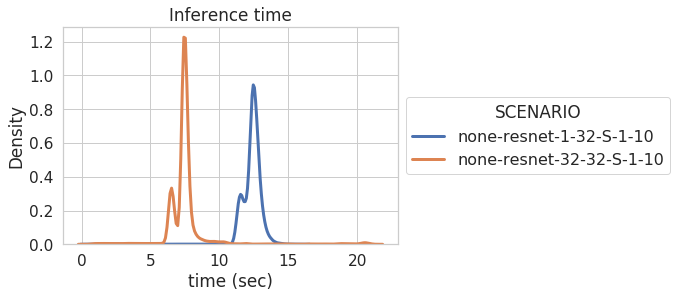

cpumem


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/cpumem-resnet-1-32-S-1-10/mlperf_log_trace.json'

In [26]:
BINS=12
color=["blue","green","yellow","red","orange","grey"]

for sc in ['none','cpumem','cpumemory']:
    print(sc)
    SCEN=[sc+'-resnet-1-32-S-1-10',
#           sc+'-resnet-2-32-S-1-10',
#              sc+'-resnet-4-32-S-1-10',
#                sc+'-resnet-8-32-S-1-10',
#           sc+'-resnet-16-32-S-1-10',
          sc+'-resnet-32-32-S-1-10']
    x=0
    for add in SCEN:
        df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/"+add+"/mlperf_log_trace.json")
        df1 = df[df["name"].isin(["Sample"])]
        print(max(df1['issue_to_done'])/ 1e6)
        print(np.median(df1['issue_to_done'])/ 1e6)
        print(np.mean(df1['issue_to_done'])/ 1e6)
    #     ax = df1['issue_to_done'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
    #     ax.set_title('Inference time (usec)');
    #     x = x+1
    #     plt.show()

        # Draw the density plot
        sns.distplot(df1['issue_to_done'] / 1e6, hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = SCEN[x])
        x=x+1

    # Plot formatting
    plt.legend(prop={'size': 16}, title = 'SCENARIO',loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.title('Inference time')
    plt.xlabel('time (sec)')
    plt.ylabel('Density')
    plt.show()

none
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
1250.919684734
612.353612573
614.556890284423
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-32-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
258.069063535
120.75396019150001
122.63092723727208


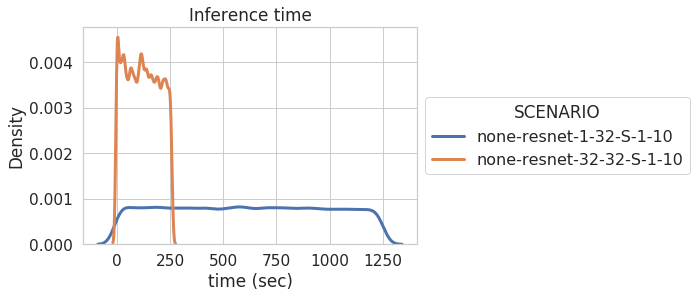

cpumem


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/cpumem-resnet-1-32-S-1-10/mlperf_log_trace.json'

In [27]:
BINS=12
color=["blue","green","yellow","red","orange","grey"]

for sc in ['none','cpumem','cpumemory']:
    print(sc)
    SCEN=[sc+'-resnet-1-32-S-1-10',
#           sc+'-resnet-2-32-S-1-10',
#              sc+'-resnet-4-32-S-1-10',
#                sc+'-resnet-8-32-S-1-10',
#           sc+'-resnet-16-32-S-1-10',
          sc+'-resnet-32-32-S-1-10']
    x=0
    for add in SCEN:
        df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/"+add+"/mlperf_log_trace.json")
        df1 = df[df["name"].isin(["Latency"])]
        print(max(df1['issue_delay'])/ 1e6)
        print(np.median(df1['issue_delay'])/ 1e6)
        print(np.mean(df1['issue_delay'])/ 1e6)
    #     ax = df1['issue_to_done'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
    #     ax.set_title('Inference time (usec)');
    #     x = x+1
    #     plt.show()

        # Draw the density plot
        sns.distplot(df1['issue_delay'] / 1e6, hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = SCEN[x])
        x=x+1

    # Plot formatting
    plt.legend(prop={'size': 16}, title = 'SCENARIO',loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.title('Inference time')
    plt.xlabel('time (sec)')
    plt.ylabel('Density')
    plt.show()

none
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-32-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>


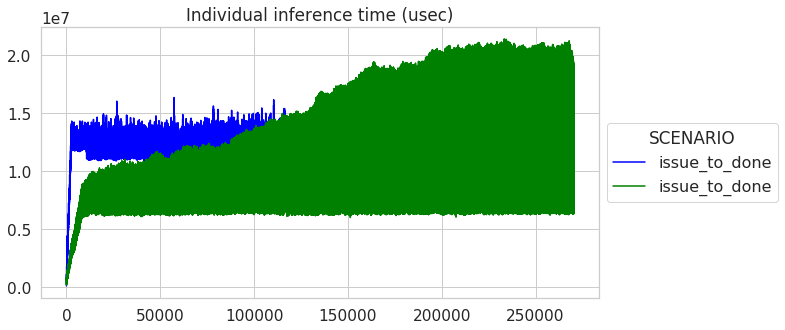

cpumem


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/cpumem-resnet-1-32-S-1-10/mlperf_log_trace.json'

In [29]:
BINS=12
color=["blue","green","yellow","red","orange","grey"]
for sc in ['none','cpumem','cpumemory']:
    print(sc)
    SCEN=[sc+'-resnet-1-32-S-1-10',
#           sc+'-resnet-2-32-S-1-10',
#              sc+'-resnet-4-32-S-1-10',
#                sc+'-resnet-8-32-S-1-10',
#           sc+'-resnet-16-32-S-1-10',
          sc+'-resnet-32-32-S-1-10']
    x=0
    for add in SCEN:
        df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/"+add+"/mlperf_log_trace.json")
        df1 = df[df["name"].isin(["Latency"])]
        df1.reset_index(drop=True,inplace=True)
#         ax = df1['issue_delay'].plot(figsize=figsize, color=color[x])
        ax = df1['issue_to_done'].plot(figsize=figsize, color=color[x])
        ax.set_title('Individual inference time (usec)');
    #     ax.set(ylim=(0, 100))
        x=x+1
    plt.legend(prop={'size': 16}, title = 'SCENARIO',loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.show()

In [28]:
# df1 = df[df["name"].isin(["Latency"])]
# ax = df1['issue_to_done'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
# ax.set_title('Inference time (usec)');
# #ax.set(xlim=(0, 25000))
# plt.xticks(rotation=60)
# plt.show()

# ax = df1['issue_to_done'].plot(figsize=figsize)
# ax.set_title('Individual inference time (usec)');
# #ax.set(ylim=(0, 200))
# plt.show()


# # df1['issue_to_done'].describe()

In [29]:
# df1 = df[df["name"].isin(["QuerySamplesComplete"])]
# df1['delta'] = df1['ts'].diff()
# ax = df1['delta'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
# ax.set_title('Time between QuerySamplesComplete (usec)');
# plt.show()

# ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
# ax.set_title('Time QuerySamplesComplete (usec)');

# offline scenario

In [475]:
BINS=12
color=["blue","green","yellow","red","orange","grey"]
SCEN=[
    'none-resnet-1-32-O-1-10',
      'none-resnet-2-32-O-1-10',
            'none-resnet-4-32-O-1-10',
           'none-resnet-8-32-O-1-10',
      'none-resnet-16-32-O-1-10',
      'none-resnet-32-32-O-1-10'
]
x=0
for add in SCEN:
    df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/"+add+"/mlperf_log_trace.json")
    df1 = df[df["name"].isin(["IssueQuery"])]
    print(df1)
#     ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
#     ax.set_title('IssueQuery duration (usec)');
#     x=x+1
#     plt.show()

# df1['delta'].describe()

<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/none-resnet-1-32-O-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
               ts        name           dur  issue_start_ns  complete_ns  \
46592  167409.695  IssueQuery  2.226891e+08             NaN          NaN   

       issue_to_done  
46592            NaN  
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/none-resnet-2-32-O-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
               ts        name           dur  issue_start_ns  complete_ns  \
46594  182404.083  IssueQuery  1.674079e+08             NaN          NaN   

       issue_to_done  
46594            NaN  
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/none-resnet-4-32-O-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
               ts        name           dur  issue_start_ns  comp

In [280]:
# # for SingleStream
# if True:
#     df1 = df[df["name"].isin(["QuerySamplesComplete"])]
#     ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
#     ax.set_title('Inference time (usec)');
#     plt.show()
#     ax = df1['dur'].plot(figsize=figsize)
#     ax.set(ylim=(0, 600))
#     ax.set_title('Individual inference time (usec)');

<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-1-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
45.704
12.454
13.523547770700635
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-2-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
52.232
12.804
14.602484076433116
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-4-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
52.981
12.078
13.179490445859877
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-8-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
54.929
12.65
13.860337579617836
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-16-32-O-32-10/mlperf_log_trace.j

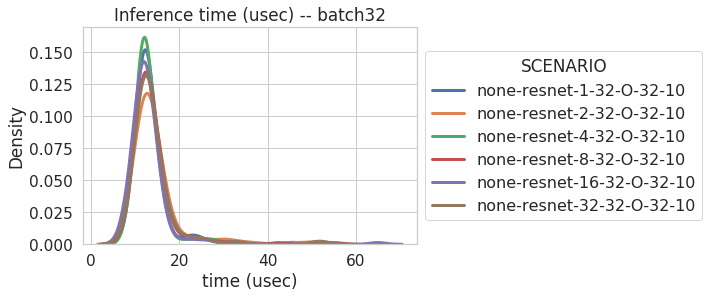

In [50]:
BINS=12
color=["blue","green","yellow","red","orange","grey"]
for batch in ['32']:
    SCEN=[
        'none-resnet-1-32-O-'+batch+'-10',
          'none-resnet-2-32-O-'+batch+'-10',
                'none-resnet-4-32-O-'+batch+'-10',
               'none-resnet-8-32-O-'+batch+'-10',
          'none-resnet-16-32-O-'+batch+'-10',
          'none-resnet-32-32-O-'+batch+'-10'
    ]
    x=0
    for add in SCEN:
        df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/"+add+"/mlperf_log_trace.json")
        df1 = df[df["name"].isin(["QuerySamplesComplete"])]
        print(max(df1['dur']))
        print(np.median(df1['dur']))
        print(np.mean(df1['dur']))
    #     ax = df1['issue_to_done'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
    #     ax.set_title('Inference time (usec)');
    #     x = x+1
    #     plt.show()

        # Draw the density plot
        sns.distplot(df1['dur'], hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = SCEN[x])
        x=x+1

    # Plot formatting
    plt.legend(prop={'size': 16}, title = 'SCENARIO',loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.title('Inference time (usec) -- batch'+str(batch))
    plt.xlabel('time (usec)')
    plt.ylabel('Density')
    plt.show()

<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-1-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
5000
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-2-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
5000
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-4-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
5000
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-8-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
5000
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/none-resnet-16-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
5000
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classificat

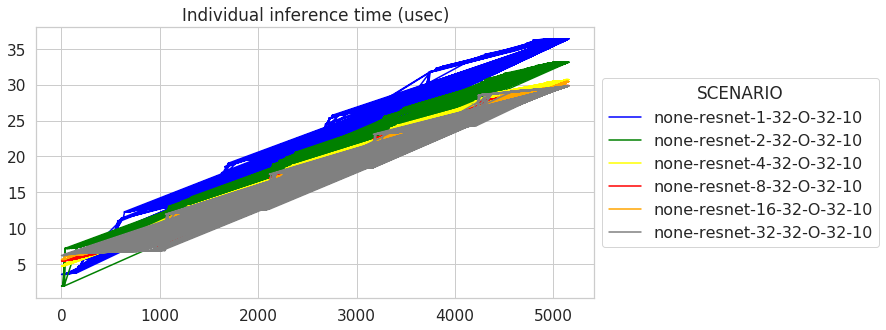

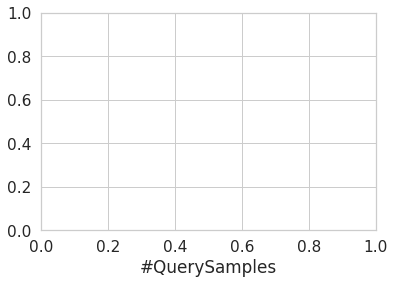

In [49]:
BINS=12
color=["blue","green","yellow","red","orange","grey"]
for batch in ['32']:
    SCEN=[
        'none-resnet-1-32-O-'+batch+'-10',
          'none-resnet-2-32-O-'+batch+'-10',
                'none-resnet-4-32-O-'+batch+'-10',
               'none-resnet-8-32-O-'+batch+'-10',
          'none-resnet-16-32-O-'+batch+'-10',
          'none-resnet-32-32-O-'+batch+'-10'
    ]
    x=0
    for add in SCEN:
        df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp24/"+add+"/mlperf_log_trace.json")
        df1 = df[df["name"].isin(["Sample"])]
        print(len(df1))
#         df1.reset_index(drop=True,inplace=True)
        ax = df1['issue_to_done'].plot(figsize=figsize, color=color[x],label = SCEN[x])
        ax.set_title('Individual inference time (usec)');
#         ax.set(ylim=(0, 150))
        x=x+1
    plt.legend(prop={'size': 16}, title = 'SCENARIO',loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.show()
    plt.xlabel('#QuerySamples')

<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/none-resnet-1-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/none-resnet-2-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/none-resnet-4-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/none-resnet-8-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/none-resnet-16-32-O-32-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-

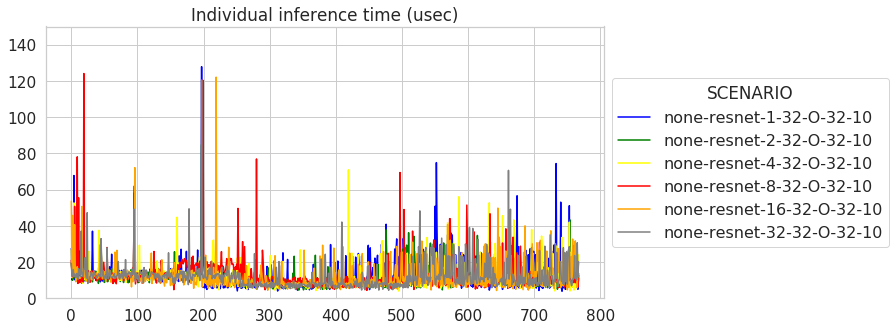

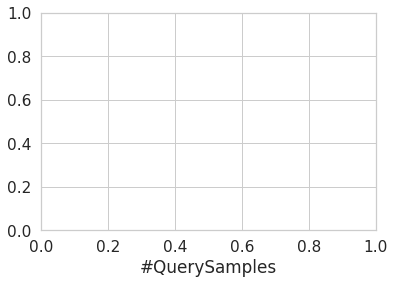

In [44]:
BINS=12
color=["blue","green","yellow","red","orange","grey"]
for batch in ['32']:
    SCEN=[
        'none-resnet-1-32-O-'+batch+'-10',
          'none-resnet-2-32-O-'+batch+'-10',
                'none-resnet-4-32-O-'+batch+'-10',
               'none-resnet-8-32-O-'+batch+'-10',
          'none-resnet-16-32-O-'+batch+'-10',
          'none-resnet-32-32-O-'+batch+'-10'
    ]
    x=0
    for add in SCEN:
        df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/"+add+"/mlperf_log_trace.json")
        df1 = df[df["name"].isin(["QuerySamplesComplete"])]
        df1.reset_index(drop=True,inplace=True)
        ax = df1['dur'].plot(figsize=figsize, color=color[x],label = SCEN[x])
        ax.set_title('Individual inference time (usec)');
        ax.set(ylim=(0, 150))
        x=x+1
    plt.legend(prop={'size': 16}, title = 'SCENARIO',loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.show()
    plt.xlabel('#QuerySamples')

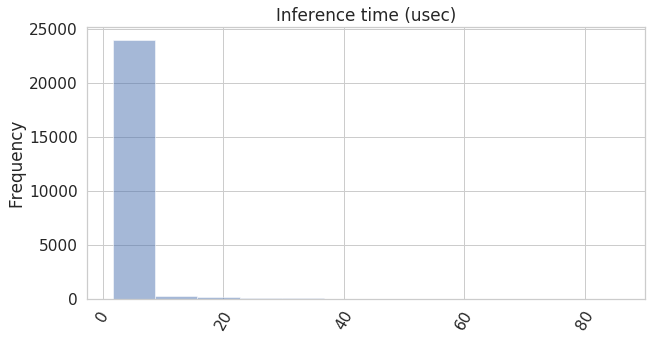

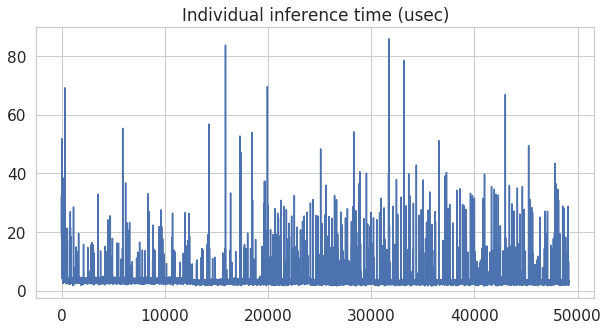

In [312]:
df1 = df[df["name"].isin(["QuerySamplesComplete"])]
ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
ax.set_title('Inference time (usec)');
#ax.set(xlim=(0, 25000))
plt.xticks(rotation=60)
plt.show()

ax = df1['dur'].plot(figsize=figsize)
ax.set_title('Individual inference time (usec)');
#ax.set(ylim=(0, 200))
plt.show()


# df1['issue_to_done'].describe()

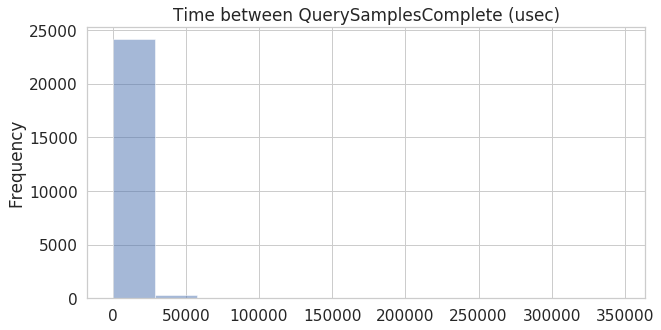

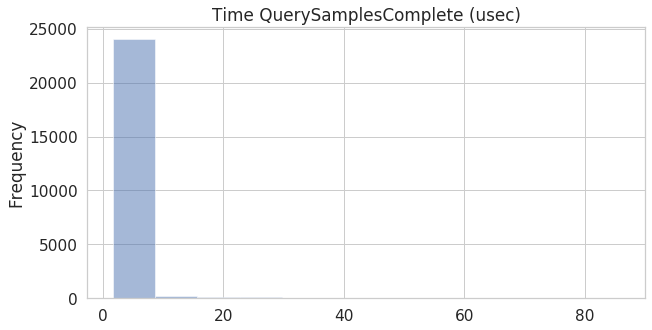

In [313]:
df1 = df[df["name"].isin(["QuerySamplesComplete"])]
df1['delta'] = df1['ts'].diff()
ax = df1['delta'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
ax.set_title('Time between QuerySamplesComplete (usec)');
plt.show()

ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
ax.set_title('Time QuerySamplesComplete (usec)');